In [74]:
import pandas as pd
import networkx as nx
import os
from matplotlib import pyplot as plt
from shapely import wkb
%matplotlib inline

In [305]:
path = 'BXB Digital - Carto/'
locations = pd.read_csv(path + 'locations.csv', delimiter='|')
geocoded_locations = pd.read_csv(path + 'locations_geocoded.csv')
movements = pd.read_csv(path + 'movements.csv', delimiter='|')
partners = pd.read_csv(path + 'partners.csv', delimiter='|')
products = pd.read_csv(path + 'products.csv', delimiter='|')

/Users/mho/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [302]:
# Group by origin-destination pairs and sum quantities
grouped_quantity = movements.groupby(['fromLocationId','toLocationId']).quantity.sum()

In [303]:
# Reset the index to get fromLocationId and toLocationId out of index
grouped = pd.DataFrame(grouped_quantity).reset_index()

In [306]:
# Drop any locations with null geometries
geocoded_locations = geocoded_locations.dropna(subset=['the_geom'])

In [307]:
# Extract the latitude and longitude from the hex
x_point = geocoded_locations.the_geom.apply(lambda x: wkb.loads(x, hex=True).x)
geocoded_locations['longitude'] = x_point
y_point = geocoded_locations.the_geom.apply(lambda x: wkb.loads(x, hex=True).y)
geocoded_locations['latitude'] = y_point

In [308]:
geocoded_locations=geocoded_locations.reset_index()

In [330]:
grouped_geocoded = pd.merge(grouped, geocoded_locations[['the_geom','locationid']], how='inner', left_on=['fromLocationId'], right_on=['locationid'])
grouped_geocoded = pd.merge(grouped_geocoded, geocoded_locations[['the_geom','locationid']], how='inner', left_on=['toLocationId'], right_on=['locationid'])

In [332]:
location_positions={}
for c in geocoded_locations.index:
    location_positions[geocoded_locations['locationid'][c]]=(geocoded_locations['longitude'][c],geocoded_locations['latitude'][c])

In [338]:
bxb_grouped = nx.from_pandas_dataframe(grouped_geocoded.head(1000), 'fromLocationId', 'toLocationId', edge_attr='quantity')

In [339]:
edge_quants = grouped.quantity.head(20)
edge_norms = (edge_quants/edge_quants.max())*10

In [340]:
positions = nx.spring_layout(bxb_grouped)

(-120.0, 60.0, -60.0, 60.0)

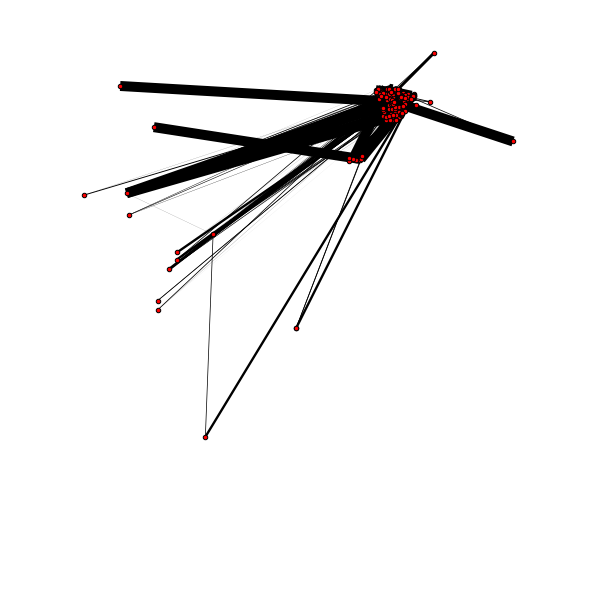

In [341]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(bxb_grouped, pos = location_positions, node_size=20, edge_color=list(grouped.quantity.head(200)))
nx.draw_networkx_edges(bxb_grouped, pos = location_positions, width=edge_norms)
plt.axis('off')